# Análisis exploratorio avanzado (EDA)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re


In [2]:
videogames_data = pd.read_csv('data/videogames_processed.csv')

In [3]:
videogames_data.head(5)

,appid,name,developer,publisher,positive,negative,owners,average_forever,median_forever,price,initialprice,languages,release_date,owners_min,owners_max,owners_min_text,owners_max_text
0,570,dota 2,Valve,Valve,1777245,389764,"200,000,000 .. 500,000,000",39211,822,0.00,0.00,573082,2013-07-09,200000000,500000000,200M,500M
1,730,counter-strike: global offensive,Valve,Valve,6892618,982541,"100,000,000 .. 200,000,000",29752,5360,0.00,0.00,1086164,2012-08-21,100000000,200000000,100M,200M
2,578080,pubg: battlegrounds,"KRAFTON, Inc.","KRAFTON, Inc.",1333940,965634,"50,000,000 .. 100,000,000",24257,6344,0.00,0.00,490082,2017-12-21,50000000,100000000,50M,100M
3,1063730,new world,Amazon Games,Amazon Games,191896,80619,"50,000,000 .. 100,000,000",10660,3893,37.19,37.19,12707,2021-09-28,50000000,100000000,50M,100M
4,440,team fortress 2,Valve,Valve,964115,62958,"50,000,000 .. 100,000,000",7732,319,0.00,0.00,85168,2007-10-10,50000000,100000000,50M,100M


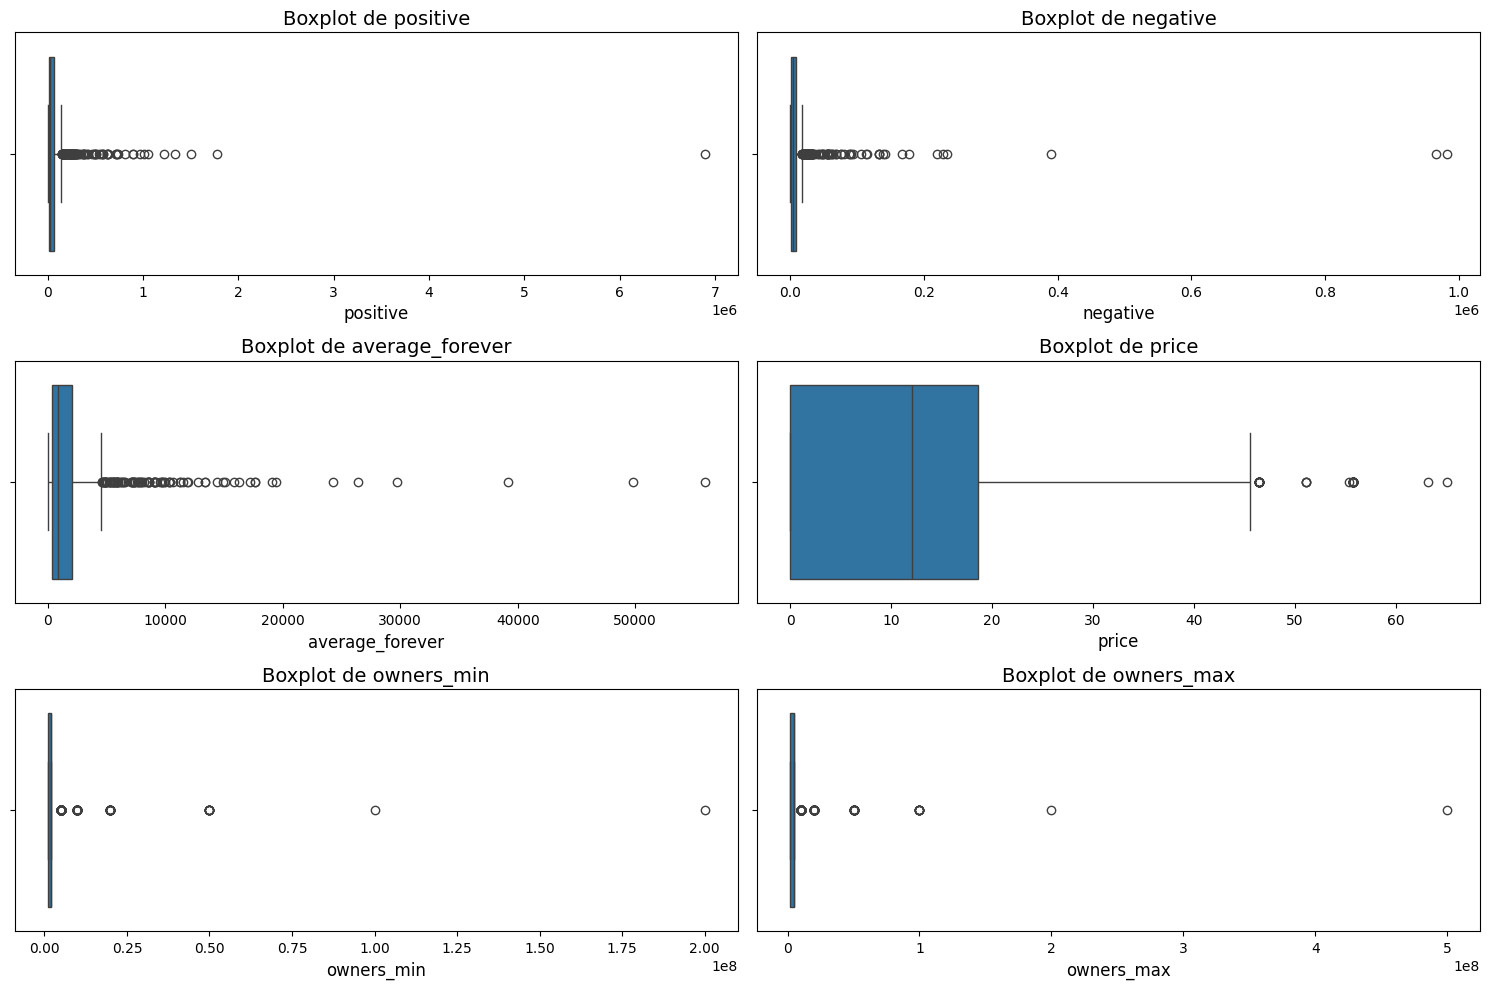

In [230]:
# Columnas de interés para revisar outliers
columns_to_check = ['positive', 'negative', 'average_forever', 'price', 'owners_min', 'owners_max']

# Figura y conjunto de subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))

# Aplanar el array de axes para facilitar su acceso
axes = axes.flatten()

for i, column in enumerate(columns_to_check):
    sns.boxplot(x=videogames_data[column], ax=axes[i])
    axes[i].set_title(f'Boxplot de {column}', fontsize=14)
    axes[i].set_xlabel(column, fontsize=12)

plt.tight_layout()
plt.show()



Comprobamos los outliers y vemos que representan datos válidos.

C:\Users\David\AppData\Local\Temp\ipykernel_15892\1618990790.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



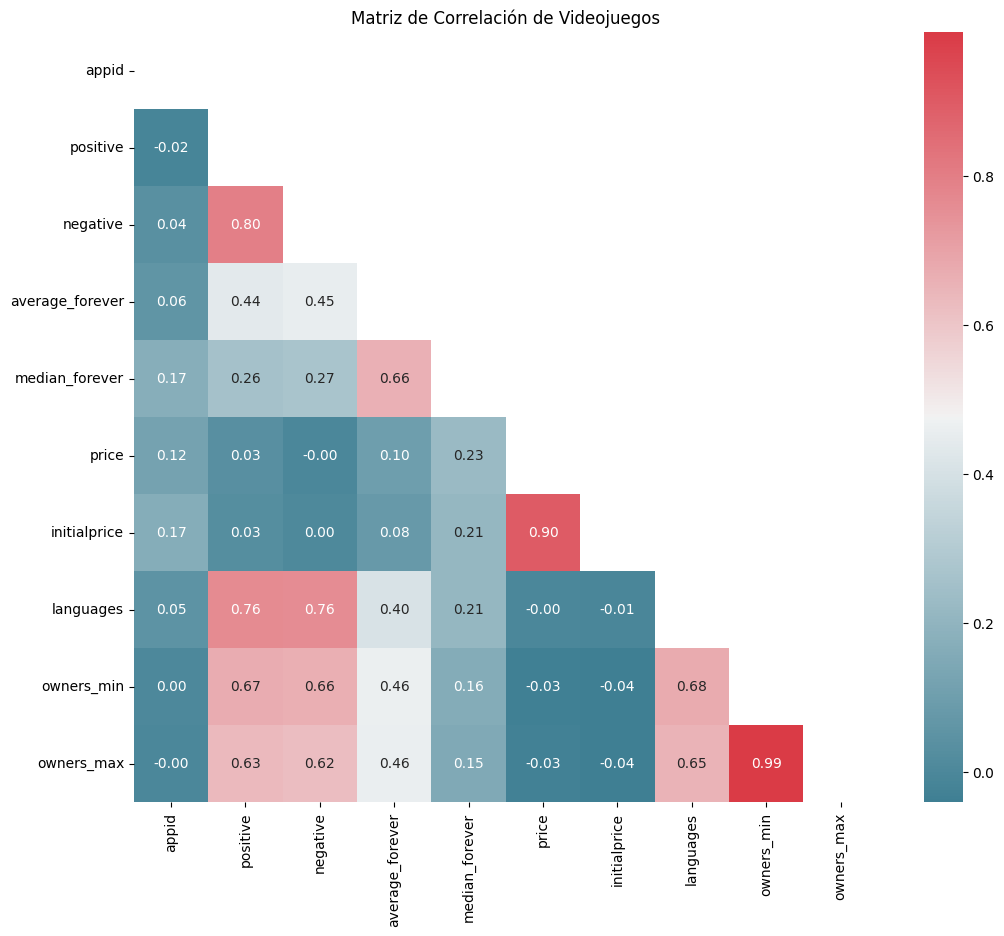

In [231]:
# Calcular la matriz de correlación
correlation_matrix = videogames_data.corr(method="pearson")

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Dibujar el gráfico de calor de la matriz de correlación
plt.figure(figsize=(12, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", mask=mask, cmap=cmap, cbar=True)
plt.title("Matriz de Correlación de Videojuegos")
plt.show()

Observamos fuertes correlaciones entre 'owners_min' y 'owners_max', 'price' y 'initialprice', 'negative' y 'positive', lo cual tiene sentido ya que estas variables están directamente relacionadas

In [232]:
# Crear un gráfico de dispersión con Plotly Express
fig = px.scatter(videogames_data, x="average_forever", y="positive",
                 title="Relación entre el Tiempo de Juego Promedio y las Reseñas Positivas",
                 labels={"average_forever": "Tiempo de Juego Promedio (min)", "positives": "Reseñas Positivas"},
                 hover_data=["name", "price"],
                 template="plotly_dark",
                 color="price") 

fig.show()

# Exportar el gráfico como HTML
# fig.write_html("graphs/6.html")


- Observamos al mayoría de puntos concentrados en el extremo inferior izquierdo, lo que sugiere que la mayoría de los juegos tienen un tiempo de juego promedio relativamente bajo y un nº menor de reseñas positivas.
- Vemos una leve tendencia que sugiere que los juegos con más tiempo de juego promedio pueden tener más reseñas positivas.
- Podemos apreciar como hay menos juegos con un tiempo de juego muy alto, lo cual es esperable ya que los juegos con largas horas de juego suelen ser menos comunes a día de hoy.
- El tiempo de juego promedio de la mayoría de los juegos es bajo, con algunos alcanzando valores más altos. Esto refleja el hecho de que hay muchos juegos casuales o con una experiencia de juego más corta en la plataforma.

In [233]:
# Convertimos 'release_date' a datetime
videogames_data['release_date'] = pd.to_datetime(videogames_data['release_date'])

# Extraer el año de la fecha de lanzamiento.
videogames_data['release_year'] = videogames_data['release_date'].dt.year

# Calcular métricas anuales como el tiempo jugado promedio por año.
annual_avg_playtime = videogames_data.groupby('release_year')['average_forever'].mean().reset_index()

# Crear un gráfico de líneas con Plotly para visualizar la tendencia a lo largo del tiempo.
fig = px.line(annual_avg_playtime, x='release_year', y='average_forever',
              title='Tiempo de Juego Promedio por Año de Lanzamiento',
              labels={'release_year': 'Año de Lanzamiento', 'average_forever': 'Tiempo de Juego Promedio (min)'},
              template="plotly_dark")


fig.show()

# Exportar el gráfico como HTML
# fig.write_html("graphs/7.html")


- Los primeros años, especialmente antes de 1995, tienen un tiempo de juego promedio más bajo. Esto podría deberse a la naturaleza de los juegos de esa época, que a menudo eran más simples y cortos.
- Después del pico del año 2000, parece haber una tendencia más estable en el tiempo de juego promedio, con algunos altibajos. La estabilización puede reflejar una madurez en la industria del juego, con lanzamientos más consistentes en términos de la duración del juego.
- Hay una ligera tendencia a la baja en los últimos años mostrados en el gráfico. Esto podría reflejar un cambio en la industria hacia juegos que son más cortos o quizás una mayor presencia de juegos independientes que tienden a tener experiencias de juego más breves en comparación con otros títulos.

In [234]:
# Creo categorías de precio basadas en rangos apropiados.
bins = [0, 5, 15, 30, 50, videogames_data['price'].max()]
labels = ['Gratis o Muy Barato 0-5', 'Barato 5-15', 'Moderado 15-30', 'Caro 30-50', 'Muy Caro +50']
videogames_data['price_category'] = pd.cut(videogames_data['price'], bins=bins, labels=labels, include_lowest=True)

# Calculamos el número total de juegos por categoría de precio
total_games_per_category = videogames_data['price_category'].value_counts()

# Calculo métricas de popularidad y reseñas por categoría de precio.
price_popularity = videogames_data.groupby('price_category').agg({
    'positive': 'mean',
    'negative': 'mean',
}).reset_index()

# Calculo el número total de reseñas (positivas y negativas) por categoría de precio
videogames_data['total_reviews'] = videogames_data['positive'] + videogames_data['negative']
total_reviews_per_category = videogames_data.groupby('price_category')['total_reviews'].sum()

# Agregamos estas nuevas métricas a el DataFrame de popularidad de precio
price_popularity['total_games'] = price_popularity['price_category'].map(total_games_per_category)
price_popularity['total_reviews'] = price_popularity['price_category'].map(total_reviews_per_category)

# Creo un gráfico para visualizar las métricas de popularidad por categoría de precio.
fig = px.bar(price_popularity, x='price_category', y=['positive', 'negative'],
             title="Popularidad y Reseñas por Categoría de Precio",
             labels={'value': 'Promedio', 'variable': 'Métrica', 'price_category': 'Categoría de precio'},
             template="plotly_dark")

# Agrego información adicional para mostrar al pasar el ratón por encima de las barras
fig.update_traces(hovertemplate="<br>".join([
    "Categoría: %{x}",
    "Total de Juegos: %{customdata[0]}",
    "Total de Reseñas: %{customdata[1]}"
]))

# Agrego el total de juegos y reseñas como datos personalizados para el hovertemplate
fig.update_traces(customdata=price_popularity[['total_games', 'total_reviews']].values)

fig.show()

# Exportar el gráfico como HTML
#fig.write_html("graphs/8.html")


In [235]:
# Creo categorías de precio basadas en rangos apropiados.
bins = [0, 5, 15, 30, 50, videogames_data['price'].max()]
labels = ['Gratis o Muy Barato 0-5', 'Barato 5-15', 'Moderado 15-30', 'Caro 30-50', 'Muy Caro +50']
videogames_data['price_category'] = pd.cut(videogames_data['price'], bins=bins, labels=labels, include_lowest=True)


# Modificación: calcular el total de reseñas positivas y negativas por categoría de precio
total_positive_reviews = videogames_data.groupby('price_category')['positive'].sum()
total_negative_reviews = videogames_data.groupby('price_category')['negative'].sum()


# Agregar estos totales al DataFrame de popularidad de precio
price_popularity['total_positive_reviews'] = price_popularity['price_category'].map(total_positive_reviews)
price_popularity['total_negative_reviews'] = price_popularity['price_category'].map(total_negative_reviews)

# Crear el gráfico
fig = px.bar(price_popularity, x='price_category', y=['positive', 'negative'],
             title="Popularidad y Reseñas por Categoría de Precio",
             labels={'value': 'Promedio', 'variable': 'Métrica', 'price_category': 'Categoría de precio'},
             template="plotly_dark", barmode='group')

# Ajustar el hovertemplate para mostrar datos relevantes
fig.update_traces(
    hovertemplate="<br>".join([
        "Categoría: %{x}",
        "Promedio: %{y}",
        "Total de Juegos: %{customdata[0]}",
        "Total de Reseñas: %{customdata[1]}",
    ])
)

# Asignar datos personalizados para hovertemplate
for trace, metric in zip(fig.data, ['total_positive_reviews', 'total_negative_reviews']):
    if metric == 'total_positive_reviews':
        custom_data = price_popularity[['total_games', 'total_positive_reviews']].values
    else:  # 'total_negative_reviews'
        custom_data = price_popularity[['total_games', 'total_negative_reviews']].values
    trace.customdata = custom_data

fig.show()

# Exportar el gráfico como HTML
# fig.write_html("graphs/8.html")


- Los juegos en las categorías "Caro" y "Muy Caro" reciben más reseñas que el resto. Esto puede deberse a los títulos AAA o de gran presupuesto.
- También es cierto que hay menos juegos en estas categorías de precio más alto, y para cada uno de estos juegos se atraen más reseñas promedio.
- Los consumidores que invierten más dinero en el juego pueden sentirse más comprometidos a proporcionar retroalimentación a través de las reseñas.
- En todas las categorías de precio, las reseñas positivas superan en número a las negativas. Esto podría indicar que, en general, hay una tendencia positiva en las opiniones de los usuarios sobre los videojuegos en Steam, independientemente del precio.

In [236]:
# Filtramos juegos con más de 100M de usuarios
videogames_filtered = videogames_data[videogames_data['owners_max'] >= 100e6]

# Ordenamos por owners_max
videogames_filtered = videogames_filtered.sort_values('owners_max', ascending=False)

# Formateamos las fechas para eliminar la hora, convirtiéndolas a formato de cadena solo con la fecha
videogames_filtered['release_date'] = pd.to_datetime(videogames_filtered['release_date']).dt.date

# Creamos el gráfico de barras utilizando 'text' para el hover data, pero evitando que se muestre sobre las barras
fig = px.bar(videogames_filtered, x='name', y='owners_max',
             color='name', 
             labels={'name': 'Juego', 'owners_max': 'Usuarios Máximos'},
             title='Juegos con más de 100M de usuarios con fecha de lanzamiento',
             template='plotly_dark',
             text=videogames_filtered['release_date'])  

# Ajustamos textposition para que el texto (fechas) no se muestre en las barras
fig.update_traces(hovertemplate="Juegos: %{x}<br>Fecha de Lanzamiento: %{text}<br>Usuarios Máximos: %{y}",
                  textposition='none')

# Ajustamos la altura del gráfico
fig.update_layout(height=500)

fig.show()

# Exportar el gráfico como HTML
#fig.write_html("graphs/9.html")

In [16]:
# Agrupar por 'publisher', contar los juegos y calcular el precio promedio
publisher_counts = videogames_data['publisher'].value_counts()
top_publishers = publisher_counts.head(15).index
top_publishers_data = videogames_data[videogames_data['publisher'].isin(top_publishers)]
avg_price_by_publisher = top_publishers_data.groupby('publisher')['price'].mean().sort_values(ascending=False)

# Crear el gráfico de barras con el precio promedio por distribuidora
fig = px.bar(
    avg_price_by_publisher,
    x=avg_price_by_publisher.values,
    y=avg_price_by_publisher.index,
    labels={'x': 'Precio Promedio', 'y': 'Distribuidora'},
    title='Precio promedio de las 15 distribuidoras con más juegos publicados',
    template='plotly_dark',
    color=avg_price_by_publisher.values,  # Usamos el precio promedio para el color de nuevo
)

# Personalizar el hovertemplate para mostrar solo la información deseada
fig.update_traces(hovertemplate='Distribuidora: %{y}<br>Precio Promedio: %{x:.2f}')

# Actualizar configuraciones de layout para claridad
fig.update_layout(yaxis_title='Distribuidora', xaxis_title='Precio Promedio', height=500)

fig.show()

# Exportar el gráfico como HTML
# fig.write_html("graphs/10.html")

In [238]:
# Calcular la suma de usuarios máximos por distribuidora
publisher_users = videogames_data.groupby('publisher')['owners_max'].sum().sort_values(ascending=False).head(15)

# Convertir la Serie a DataFrame para visualización
publisher_users_df = publisher_users.reset_index()

# Crear el gráfico de barras con Plotly
fig = px.bar(publisher_users_df, x='owners_max', y='publisher',
             title="Top 15 Distribuidoras por Usuarios Máximos",
             template="plotly_dark",
             color="publisher",
             labels={'owners_max': 'Usuarios máximos', 'publisher': 'Distribuidora'})

# Mostrar el gráfico
fig.show()

# Exportar a HTML
# fig.write_html("graphs/13.html")


In [239]:
# Calculo los ingresos por videojuego en una nueva columna
videogames_data['revenue'] = videogames_data['owners_max'] * videogames_data['price']

# Calculo la suma de ingresos por distribuidora
publisher_revenue = videogames_data.groupby('publisher')['revenue'].sum().sort_values(ascending=False).head(15)

# Convierto la Serie a DataFrame para visualización
publisher_revenue_df = publisher_revenue.reset_index()

# Creo el gráfico de pastel con Plotly Express
fig = px.pie(publisher_revenue_df, values='revenue', names='publisher',
             title="Top 15 Distribuidoras por Ingresos",
             template="plotly_dark",
             color_discrete_sequence=px.colors.sequential.RdBu)

fig.update_traces(textposition='inside', textinfo='percent+label')

# Muestra el gráfico
fig.show()


# Opcional: Exportar a HTML
#fig.write_html("graphs/14.html")


In [240]:
# Calculamos el top 15 de empresas que más videojuegos han lanzado
top_15_developers = videogames_data['developer'].value_counts().head(15)

# Creamos el gráfico de pie con Plotly
fig = px.pie(values=top_15_developers.values, names=top_15_developers.index,
             title="Top 15 Empresas que Más Videojuegos Han Lanzado",
             color_discrete_sequence=px.colors.sequential.RdBu,
             hole=0.3)

# Mejoramos el diseño del gráfico
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(template="plotly_dark")

fig.show()

# Exportar el gráfico como HTML
# fig.write_html("graphs/12.html")

In [241]:
# Calculamos el top 15 de videojuegos con más jugadores
top_15_games = videogames_data.nlargest(15, 'owners_max')

# Creamos el gráfico con Plotly
fig = px.bar(top_15_games, x='name', y='owners_max',
             title="Top 15 Videojuegos con Más Jugadores",
             labels={'owners_max': 'Número Estimado de Jugadores', 'name': 'Nombre del Videojuego'},
             color='owners_max',
             color_continuous_scale=px.colors.sequential.Viridis)

# Mejoramos el diseño del gráfico
fig.update_layout(xaxis_title="Nombre del Videojuego",
                  yaxis_title="Número Estimado de Jugadores",
                  xaxis={'categoryorder':'total descending'},
                  coloraxis_colorbar=dict(title="Jugadores"),
                  template="plotly_dark")

fig.show()

# Exportar el gráfico como HTML
# fig.write_html("graphs/11.html")

# Minería de texto con los desarrolladores de los videojuegos

In [242]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [243]:
videogames_data.developer.head()

0            Valve
1            Valve
2    KRAFTON, Inc.
3     Amazon Games
4            Valve
Name: developer, dtype: object

In [244]:
videogames_data = videogames_data[videogames_data['developer'].notnull()]

#remove numbers
videogames_data['developer'] = videogames_data['developer'].str.replace('\d+', '') 
#all to lowercase
videogames_data['developer'] = videogames_data['developer'].str.lower()
#remove windows new line
videogames_data['developer'] = videogames_data['developer'].str.replace('\r\n', "")
#remove stopwords (from nltk library)
stop_english = stopwords.words("english")
videogames_data['developer'] = videogames_data['developer'].apply(lambda x: " ".join([i for i in x.split() 
                                                      if i not in (stop_english)]))
# remove punctuation
videogames_data['developer'] = videogames_data['developer'].str.replace('[^\w\s]'," ")
# replace x spaces by one space
videogames_data['developer'] = videogames_data['developer'].str.replace('\s+', ' ')

videogames_data.developer.values[2] #print same comments again

C:\Users\David\AppData\Local\Temp\ipykernel_15892\3874167451.py:4: FutureWarning:

The default value of regex will change from True to False in a future version.

C:\Users\David\AppData\Local\Temp\ipykernel_15892\3874167451.py:14: FutureWarning:

The default value of regex will change from True to False in a future version.

C:\Users\David\AppData\Local\Temp\ipykernel_15892\3874167451.py:16: FutureWarning:

The default value of regex will change from True to False in a future version.



'krafton inc '

In [245]:
texts = videogames_data.developer.tolist()

vec = CountVectorizer().fit(texts)
bag_of_words = vec.transform(texts)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

cvec_df = pd.DataFrame.from_records(words_freq, columns= ['words', 'counts']).sort_values(by="counts", ascending=False)
cvec_df.head(10)

,words,counts
4,games,191
18,studios,124
65,interactive,84
6,entertainment,67
61,ltd,47
112,feral,46
2,inc,41
34,ubisoft,40
41,studio,39
15,software,36


In [246]:
texts = videogames_data.developer.tolist()

# Preprocesar los textos para eliminar la palabra 'ltd'
texts = [re.sub(r'\bltd\b', '', text) for text in texts]

vec = CountVectorizer().fit(texts)
bag_of_words = vec.transform(texts)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

cvec_df = pd.DataFrame.from_records(words_freq, columns=['words', 'counts']).sort_values(by="counts", ascending=False)
cvec_df.head(10)


,words,counts
4,games,191
18,studios,124
64,interactive,84
6,entertainment,67
111,feral,46
2,inc,41
34,ubisoft,40
41,studio,39
108,mac,36
15,software,36


In [247]:
# import matplotlib.pyplot as plt
# from wordcloud import WordCloud
# import random

# cvec_dict = dict(zip(cvec_df.words, cvec_df.counts))

# # Define una función de color personalizada
# def custom_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
#     # Reducir la saturación y luminosidad para colores menos intensos
#     colors = [
#         'hsl(0, 55%, 50%)',   # rojo
#         'hsl(120, 55%, 50%)', # verde
#         'hsl(240, 55%, 50%)', # azul
#         'hsl(60, 55%, 50%)',  # amarillo
#         'hsl(180, 55%, 50%)', # cian
#         'hsl(300, 55%, 50%)', # magenta
#         # ... puedes ajustar la saturación (segundo valor %) y luminosidad (tercer valor %) a tus preferencias
#     ]
#     return random.choice(colors)  # selecciona un color aleatorio de la lista

# # Crear el WordCloud
# wordcloud = WordCloud(
#     width=800,
#     height=400,
#     font_path='C:/Windows/Fonts/AniMeMatrix-MB_EN.ttf',  # Especificar el nombre de la fuente
#     color_func=custom_color_func,
#     background_color='black',
#     max_words=200
# )

# wordcloud.generate_from_frequencies(frequencies=cvec_dict)

# # Visualización
# plt.figure(figsize=(20, 10))
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()


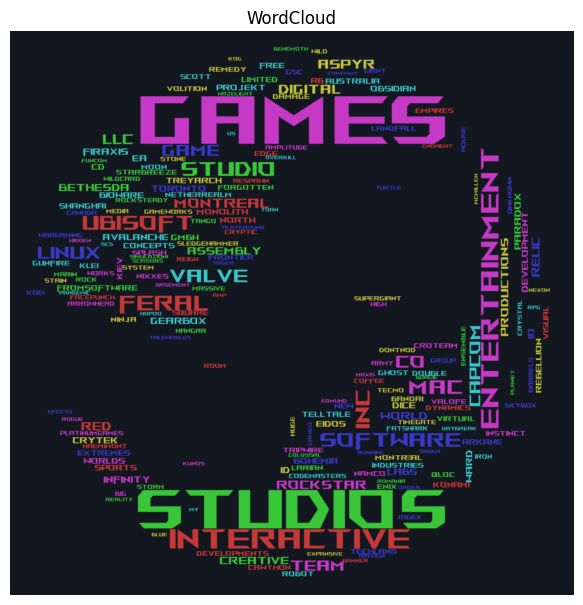

Wordcloud saved to: imgs/your_wordcloud2.png


In [248]:
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import random

def custom_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    
    colors = [
        'hsl(0, 55%, 50%)',   
        'hsl(120, 55%, 50%)', 
        'hsl(240, 55%, 50%)', 
        'hsl(60, 55%, 50%)',  
        'hsl(180, 55%, 50%)', 
        'hsl(300, 55%, 50%)', 
    ]
    return random.choice(colors)  

# Calculamos la frecuencia de las palabras
vec = CountVectorizer().fit(texts)
bag_of_words = vec.transform(texts)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

# Convertimos las frecuencias en un diccionario para WordCloud
cvec_dict = dict(words_freq)

# Cargamos la imagen del logo de Steam  y la convertimos a una máscara adecuada
image_path = 'imgs/steamlogoword.png'  # Cambia esta ruta
steam_mask_image = Image.open(image_path).convert('RGBA')
steam_mask = np.array(steam_mask_image)

# Convertimos los valores transparentes a blanco (255) y los no transparentes a negro (0)
# Esto es para la máscara en el formato que WordCloud espera
steam_mask = np.where(steam_mask[:, :, 3] == 0, 255, 0).astype(np.uint8)

# Creamos el WordCloud con la máscara
wordcloud = WordCloud(
    width=800,
    height=800,
    font_path='C:/Windows/Fonts/AniMeMatrix-MB_EN.ttf',
    color_func=custom_color_func,
    max_words=200,
    background_color='#131720',  # Fondo transparente
    mode='RGBA',  # Modo RGBA para transparencia
    mask=steam_mask,  # Usamos la máscara del logo de Steam
    max_font_size=300,  # Tamaño máximo de la fuente
    scale=2  # Escala para mayor resolución
).generate_from_frequencies(cvec_dict)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 2)
plt.title('WordCloud')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

# Guardamos el WordCloud en un archivo PNG 
output_path = 'imgs/your_wordcloud2.png'
wordcloud.to_file(output_path)
print("Wordcloud saved to:", output_path)


In [249]:
videogames_data.to_csv('data/videogames_eda.csv', index=False)